In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

def seq2vec(string, outlen, vocab):
    """
    given dictionary, convet string to a vector.
    the length of string should be shorter then outlen.
    if the length string is smaller than outlen, it will be padded with zero to make the langth the same.
    
    string: input string (length smaller than outlen)
    outlen: output length of vecotr.
    vocab: the dictionary for the encoding.
    """   
    vector = [vocab[amino_acid] for amino_acid in string]
    vector = np.pad(vector, (0,outlen-len(vector)), constant_values=20)
    return np.array(vector)

def label(row):
    if row['binding score'] > 0:
        if row['digest score'] > 0: return 0
        else: return 2      
    elif row['binding score'] <= 0:
        if row['digest score'] <= 0: return 1
        else: return 3

In [15]:
#load data
data = pd.read_csv("family_101F.csv")
vfile = pd.read_csv("vocab.csv", index_col=None, skiprows=0)
vocab = {vfile["One-Letter Code"][i]:i for i in range(len(vfile["One-Letter Code"]))}

#change vector to one-hot encoding
Tx = data["len"].max()
vector = np.array([to_categorical(seq2vec(data["seq"][i], Tx, vocab)) for i in data.index])

#label the class according to their quadrant
data.loc[(data["binding score"] + data["digest score"] > 0), "label"] = 0
data.loc[(data["binding score"] + data["digest score"] <= 0), "label"] = 1

In [ ]:
nbatch = 3200
nepoch = 200

kfold = 5
kf = KFold(n_splits=kfold, shuffle=True, random_state=1)
acc, val_acc = pd.DataFrame([]), pd.DataFrame([])

for (train_index, test_index), k in zip(kf.split(vector,data["label"]), range(kfold)):
    
    #create training/testing set with k-fold    
    trainX = vector[train_index]
    trainY = data["label"][train_index].values
    testX = vector[test_index]
    testY = data["label"][test_index].values

    #train the model
    model = Sequential()
    model.add(layers.Bidirectional(layers.SimpleRNN(units=16, input_shape=(Tx, len(vocab)), return_sequences=True)))
    model.add(layers.Bidirectional(layers.SimpleRNN(units=16, input_shape=(Tx, len(vocab)))))
    model.add(layers.Dense(units=16, activation='relu'))
    model.add(layers.Dense(units=2, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    history = model.fit(trainX, trainY, validation_data=(testX,testY), epochs=nepoch, batch_size=nbatch, verbose=1)
    
    #keep model weights and result
    acc["k"+str(k+1)] = history.history["accuracy"]
    val_acc["k"+str(k+1)] = history.history["val_accuracy"] 
    #model.save_weights('./k'+str(k)+'.ckpt')
    #clean session
    del model
    tf.keras.backend.clear_session()
    
#acc.to_csv("acc.csv", index_label=False)
#acc.to_csv("val_acc.csv", index_label=False)

In [ ]:
plt.plot(np.arange(nepoch), acc.mean(axis=1), '-', label='training set');
#plt.fill_between(np.arange(5), acc.mean(axis=1)-acc.std(axis=1),acc.mean(axis=1)+acc.std(axis=1));
plt.plot(np.arange(nepoch), val_acc.mean(axis=1), '-', label='validation set');
#plt.fill_between(np.arange(5), val_acc.mean(axis=1)-val_acc.std(axis=1),val_acc.mean(axis=1)+val_acc.std(axis=1));
plt.title("RNN + softmax");
plt.ylabel("Accuracy");
plt.xlabel("epoch");
plt.legend();

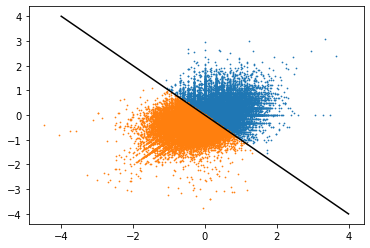

In [20]:
plt.plot(np.linspace(-4,4,50), -np.linspace(-4,4,50), c='k')
for i in range(2):
    plt.scatter( data['binding score'][data["label"] == i], data['digest score'][data["label"] == i], s=0.5)

In [49]:
y = model.predict(testX)
np.sum(np.where(testY==np.argmax(y, axis=1), 1, 0))/len(testY)

0.6955441533891439